In [1]:
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, ReLU, Concatenate, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras import layers

def stem_block(inputs):
    x = Conv2D(32, (3, 3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    branch1 = Conv2D(16, (1, 1), padding='same')(x)
    branch1 = BatchNormalization()(branch1)
    branch1 = ReLU()(branch1)
    branch1 = Conv2D(32, (3, 3), strides=2, padding='same')(branch1)

    branch2 = MaxPooling2D((2, 2), strides=2, padding='same')(x)

    x = Concatenate()([branch1, branch2])
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def dense_block(inputs, num_layers, growth_rate, bottleneck_width):
    x = inputs
    growth_rate = int(growth_rate / 2)
    inter_channel = int(growth_rate * bottleneck_width / 4) * 4

    for i in range(num_layers):
        branch1 = Conv2D(inter_channel, (1, 1), padding='same')(x)
        branch1 = BatchNormalization()(branch1)
        branch1 = ReLU()(branch1)
        branch1 = Conv2D(growth_rate, (3, 3), padding='same')(branch1)

        branch2 = Conv2D(inter_channel, (1, 1), padding='same')(x)
        branch2 = BatchNormalization()(branch2)
        branch2 = ReLU()(branch2)
        branch2 = Conv2D(growth_rate, (3, 3), padding='same')(branch2)

        x = Concatenate()([x, branch1, branch2])

    return x

def transition_block(inputs, reduction):
    x = Conv2D(int(tf.keras.backend.int_shape(inputs)[-1] * reduction), (1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((2, 2), strides=2)(x)
    return x


In [2]:
def PeleeNet(input_shape=(224, 224, 3), classes=2):
    inputs = tf.keras.Input(shape=input_shape)

    x = stem_block(inputs)

    x = dense_block(x, 10, 32, 1)
    x = transition_block(x, 0.8)

    x = dense_block(x, 16, 32, 2)
    x = transition_block(x, 0.8)

    x = dense_block(x, 16, 32, 4)
    x = transition_block(x, 0.8)

    x = dense_block(x, 16, 32, 4)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Define paths to your dataset
train_data_dir = './train/'
test_data_dir = './test/'
val_data_dir = './val/'

# Set parameters
img_width, img_height = 224, 224
batch_size = 64
epochs = 15

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # assuming binary classification (drowsy and non-drowsy)
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2149 images belonging to 2 classes.
Found 272 images belonging to 2 classes.
Found 268 images belonging to 2 classes.


In [4]:
model = PeleeNet(input_shape=(224, 224, 3), classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with your data
history = model.fit(train_generator, epochs=10, validation_data=val_generator)




Epoch 1/10


34/34 [==============================] - 513s 12s/step - loss: 0.7253 - accuracy: 0.5342 - val_loss: 1.0748 - val_accuracy: 0.5336
Epoch 2/10
34/34 [==============================] - 400s 12s/step - loss: 0.5205 - accuracy: 0.5342 - val_loss: 2.0406 - val_accuracy: 0.5336
Epoch 3/10
34/34 [==============================] - 396s 12s/step - loss: 0.4098 - accuracy: 0.5342 - val_loss: 17.9896 - val_accuracy: 0.5336
Epoch 4/10
34/34 [==============================] - 384s 11s/step - loss: 0.3713 - accuracy: 0.5342 - val_loss: 3.7494 - val_accuracy: 0.5336
Epoch 5/10
34/34 [==============================] - 372s 11s/step - loss: 0.2924 - accuracy: 0.5342 - val_loss: 30.0613 - val_accuracy: 0.5336
Epoch 6/10
34/34 [==============================] - 377s 11s/step - loss: 0.2377 - accuracy: 0.5342 - val_loss: 8.5040 - val_accuracy: 0.5336
Epoch 7/10
34/34 [==============================] - 364s 11s/step - loss: 0.2415 - accuracy: 0.5342 - val_loss: 4.1682 - val_accuracy: 0.5336

In [5]:
model.save('PeleeNet1.h5')

c:\Users\prans\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


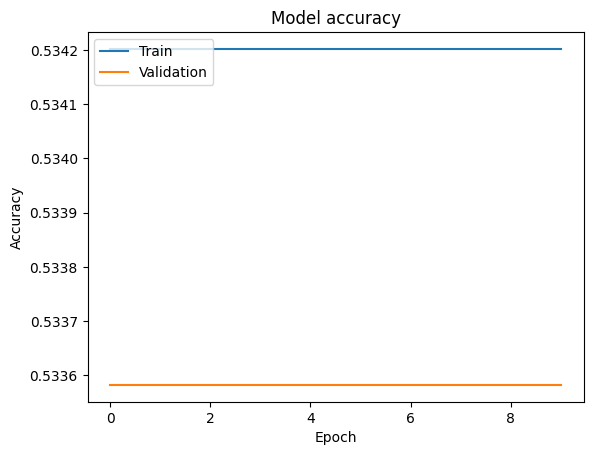

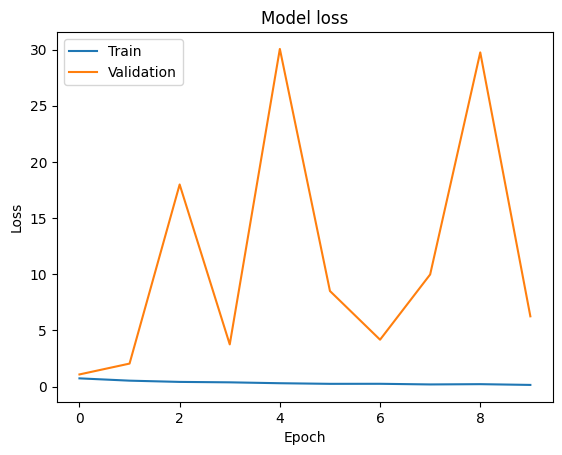

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()